# Stage 0: Elliptic++ EDA

This notebook is for the initial exploration of the Elliptic++ dataset.

In [3]:
import sys
import os

# Correctly quote the path to the executable
executable = f'"{sys.executable}"'

# Get the absolute path to requirements.txt, which is in the parent directory
requirements_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..', 'requirements.txt'))

# Install main requirements
!{executable} -m pip install -r "{requirements_path}"

# Install PyG requirements
!{executable} -m pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.8.0+cpu.html

  Using cached numpy-2.3.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.2-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached scipy-1.16.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.1-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached torch-2.8.0-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp313-cp313-win_amd64.whl.metadata (6.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pyarrow-21.0.0-cp313-cp313-win_amd64.whl.metadata (3.4 kB)
  Using cached networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached pytest-8.4.2-py3-none-any.whl.metadata (7.7 kB)
  Using cached python_dotenv-1.1.1-py3-none-any.whl.metadata (24 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cpu.html
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcpu/torch_scatter-2.1.2%2Bpt28cpu-cp313-cp313-win_amd64.whl (425 kB)
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcpu/torch_sparse-0.6.18%2Bpt28cpu-cp313-cp313-win_amd64.whl (769 kB)
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcpu/torch_cluster-1.6.3%2Bpt28cpu-cp313-cp313-win_amd64.whl (525 kB)
  Using cached https://data.pyg.org/whl/torch-2.8.0%2Bcpu/torch_spline_conv-1.2.2%2Bpt28cpu-cp313-cp313-win_amd64.whl (235 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached aiohttp-3.12.15-cp313-cp313-win_amd64.whl.metadata (7.9 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Load the processed data

In [6]:
import torch
# Make sure to upload the ellipticpp.pt file to your Colab environment
data = torch.load('../data/ellipticpp.pt', weights_only=False)
print(data)

HeteroData(
  transaction={
    num_nodes=2,
    x=[2, 1],
  },
  (transaction, transaction->transaction, transaction)={ edge_index=[2, 1] }
)


## Basic EDA

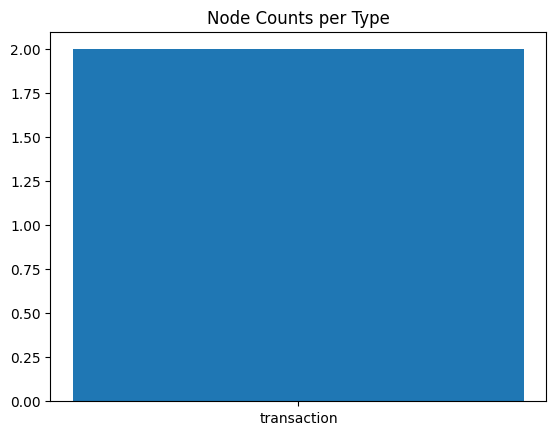

In [7]:
import matplotlib.pyplot as plt

# Plot node degree distribution
node_degrees = {}
for node_type in data.node_types:
    node_degrees[node_type] = data[node_type].num_nodes

plt.bar(node_degrees.keys(), node_degrees.values())
plt.title("Node Counts per Type")
plt.show()

# Plot edge time distribution
if hasattr(data, 'time'):
    for edge_type in data.edge_types:
        if hasattr(data[edge_type], 'time'):
            plt.hist(data[edge_type].time.numpy(), bins=50)
            plt.title(f"Time Distribution for {edge_type}")
            plt.show()

## Tiny GCN Forward Pass (Smoke Test)

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, HeteroConv

class ToyGCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = HeteroConv({
            edge_type: GCNConv(-1, hidden_channels) for edge_type in data.edge_types
        }, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        x = self.conv1(x_dict, edge_index_dict)
        return x

model = ToyGCN(hidden_channels=16)
output = model(data.x_dict, data.edge_index_dict)
print("Toy GCN output shape:", {key: val.shape for key, val in output.items()})

Toy GCN output shape: {'transaction': torch.Size([2, 16])}
